In [1]:
# Dependencies and Setup
import os
import csv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import gmaps
import scipy.stats as sts
from scipy.stats import linregress

# from sodapy import Socrata
low_memory = False
from pandas.api.types import CategoricalDtype


In [74]:
# State wide Covid-19 vaccines administered by county 
csv_data = pd.read_csv("./statewide-covid-19-vaccines-administered-by-county.csv")
ca_vaccin_data_all = csv_data.query('county =="All CA Counties"')

# Creating a dataframe with selected columns
ca_vaccin_data = pd.DataFrame(ca_vaccin_data_all, columns=['administered_date','total_doses','pfizer_doses',\
                                                         'moderna_doses','jj_doses','partially_vaccinated',\
                                                         'fully_vaccinated'])

vaccin_doses_by_dates = pd.DataFrame(ca_vaccin_data_all, columns = ['administered_date', 'total_doses', \
                                                               'partially_vaccinated', 'fully_vaccinated', 'at_least_one_dose'])

# Creating dataframe for cumulative vaccination (using for cummulative line graphs)

cumulative_vaccin_data = pd.DataFrame(ca_vaccin_data_all, columns=['administered_date','cumulative_total_doses', \
                                                        'total_partially_vaccinated','cumulative_fully_vaccinated'])

# Converting the string format of date into datetime and created a new column for month
ca_vaccin_data['month'] = pd.DatetimeIndex(ca_vaccin_data['administered_date']).month_name()

# Creating a new dataframe with months as variable to be utilized for ploting by months
ca_vaccinated = pd.DataFrame(ca_vaccin_data, columns=['month','administered_date','fully_vaccinated','partially_vaccinated'])

# The data rows that contains, month = August, are dropped as there were only two days of data in August. 

ca_vaccin_data = ca_vaccin_data[ca_vaccin_data['month'] != 'August']
# ca_vaccin_data 
# ca_vaccin_data
# ca_vaccin_data_all
vaccin_doses_by_dates


,administered_date,total_doses,partially_vaccinated,fully_vaccinated,at_least_one_dose
0,12/15/2020,1188,1188,0,1188
1,12/16/2020,8761,8761,0,8761
2,12/17/2020,26792,26794,0,26794
3,12/18/2020,45570,45570,1,45570
4,12/19/2020,25657,25656,1,25656
...,...,...,...,...,...
226,7/29/2021,76466,45950,29829,49558
227,7/30/2021,89763,53091,35760,56991
228,7/31/2021,56117,33701,21819,35940
229,8/1/2021,28162,18298,9603,19125


In [5]:
# Converting the order of months over time of the year (avoiding alphabatically ascending or descending order)
month = ca_vaccinated["month"]
values = ca_vaccinated['fully_vaccinated']
data = {
    'month' : [month],
    'value' : [values] }

month_order = CategoricalDtype(['August', 'September', 'October', 'November','December','January','February','March','April',\
                                'May','June','July'], ordered=True)

ca_vaccinated['month'] = ca_vaccinated['month'].astype(month_order)
ca_vaccinated['month'].unique()



['December', 'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August']
Categories (9, object): ['August' < 'December' < 'January' < 'February' ... 'April' < 'May' < 'June' < 'July']

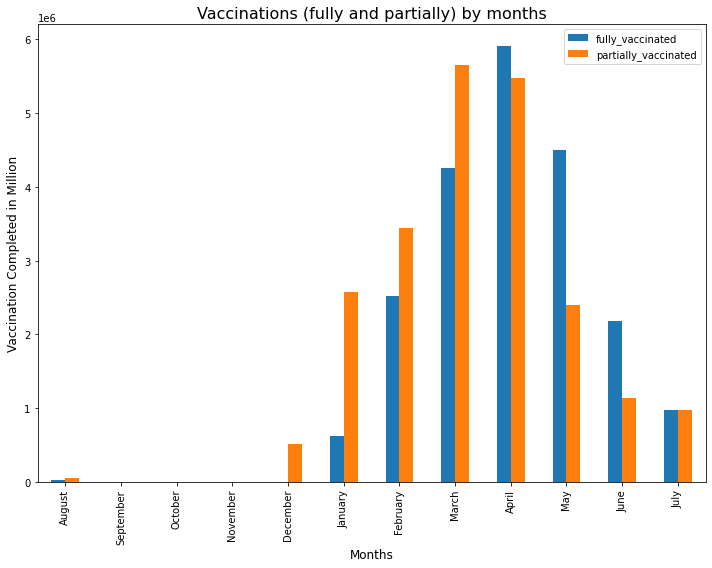

In [6]:
# Generating a bar plot showing the total number of completed vaccination by months
ca_vaccinated_monthly = pd.DataFrame(ca_vaccinated, columns=['month','fully_vaccinated', 'partially_vaccinated'])
ca_vaccinated_montly = ca_vaccinated_monthly.groupby(ca_vaccinated_monthly['month']).sum()

ca_vaccinated_montly = pd.DataFrame(ca_vaccinated_montly)

bar_plot = ca_vaccinated_montly.plot.bar(figsize=(10,8))

plt.xlabel("Months",fontsize = 12)
plt.ylabel("Vaccination Completed in Million",fontsize = 12)
plt.title("Vaccinations (fully and partially) by months",fontsize = 16)

plt.tight_layout()

plt.savefig("./CA_vaccinations_by _months.png")
plt.show()

In [7]:
ca_vaccinated_monthly.reset_index(inplace = True)
ca_vaccinated_monthly = ca_vaccinated_monthly.dropna(axis = 0)
ca_vaccinated_monthly

,index,month,fully_vaccinated,partially_vaccinated
0,0,December,0,1188
1,1,December,0,8761
2,2,December,0,26794
3,3,December,1,45570
4,4,December,1,25656
...,...,...,...,...
226,226,July,29829,45950
227,227,July,35760,53091
228,228,July,21819,33701
229,229,August,9603,18298


In [8]:
# Comapare CA cases and vaccination by months
county_cases = pd.read_csv("./Resources/cases_by_county_and_month.csv")

# Converting the order of months over time of the year (avoiding alphabatically ascending or descending order)
months = county_cases["month"]
cases = county_cases['cases']
data = {
    'month' : [month],
    'value' : [cases] }

month_in_order = CategoricalDtype(['August', 'September', 'October', 'November', 'December','January','February','March',\
                                'April','May','June','July'], ordered=True)

county_cases['month'] = county_cases['month'].astype(month_in_order)
# county_cases['month'].unique()
#

county_cases_monthly = pd.DataFrame(county_cases.groupby(county_cases['month']).sum()['cases'])
county_cases_vac_monthly= pd.merge(county_cases_monthly, ca_vaccinated_montly, on ='month', how = 'left')

county_cases_vac_monthly

,cases,fully_vaccinated,partially_vaccinated
month,,,
August,151005,28601,48530
September,100443,0,0
October,123361,0,0
November,413997,0,0
December,1214421,76,519819
January,872501,629836,2570412
February,180708,2528335,3439050
March,82301,4263081,5647493
April,64723,5907484,5479743


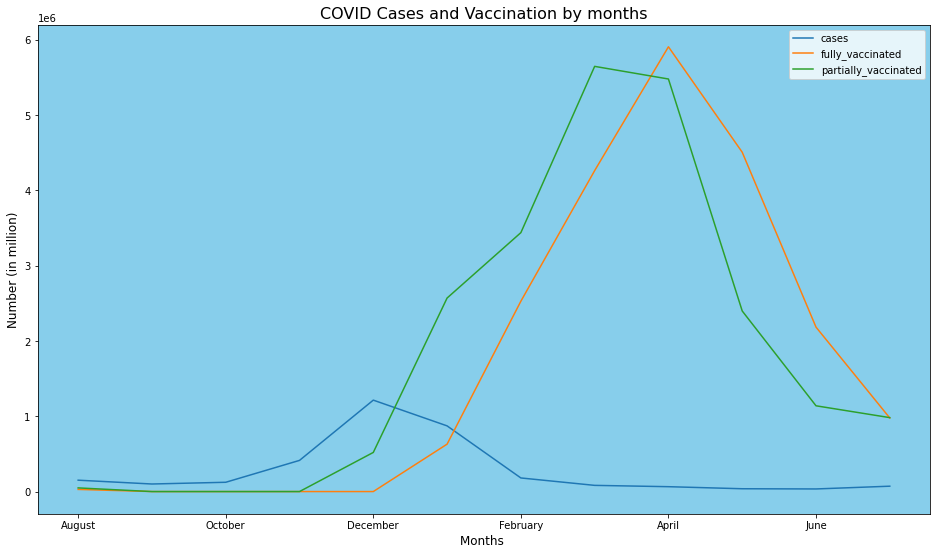

In [9]:
# bar_chart showing total cases and total completed vaccination by months (August 20 to July 21) 

county_cases_vac_monthly.plot(y = ['cases', 'fully_vaccinated', 'partially_vaccinated'], kind='line', figsize=(16,9)).set_facecolor('skyblue')

# Add labels to X and Y axes :: Add title
plt.ylabel("Number (in million)",fontsize = 12)
plt.xlabel("Months ",fontsize = 12)
plt.title("COVID Cases and Vaccination by months",fontsize = 16)

plt.savefig("./CA_cases_and_vaccinations_by _months.png")
plt.show()


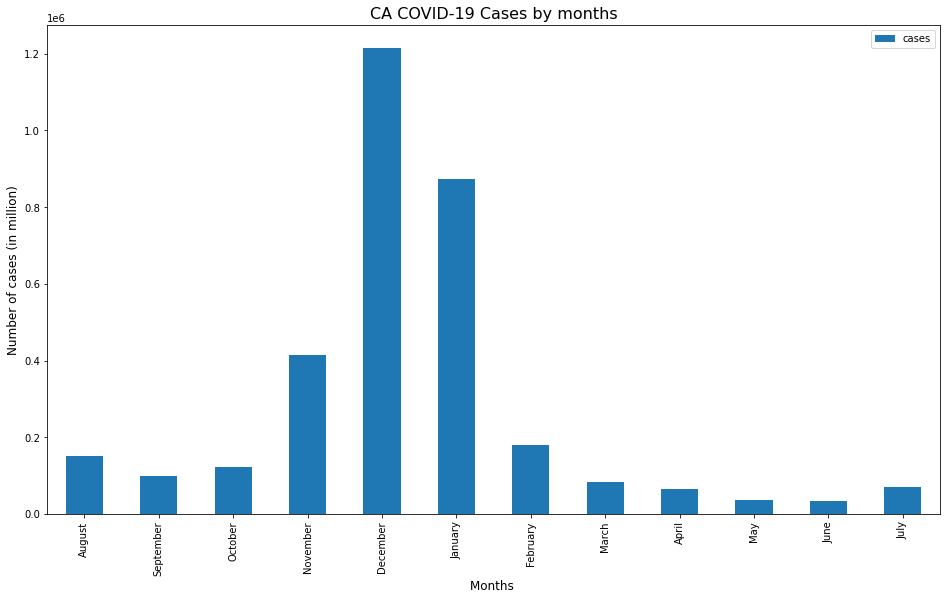

In [10]:
# California total cases by months 2021
total_cases_month = pd.read_csv("./Resources/total_monthly_cases.csv")
# print(total_cases_month)

county_cases_vac_monthly.plot(y = ['cases'], kind='bar', figsize=(16,9))
plt.ylabel("Number of cases (in million)",fontsize = 12)
plt.xlabel("Months ",fontsize = 12)
plt.title("CA COVID-19 Cases by months",fontsize = 16)

plt.savefig("./CA_total_cases_by _months.png")
plt.show()

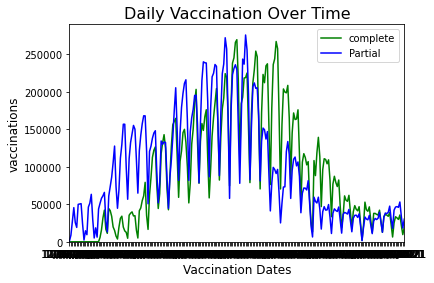

In [11]:
import matplotlib.pyplot as plt
import numpy as np

dates = ca_vaccinated['administered_date']
complete = ca_vaccinated['fully_vaccinated']
partial = ca_vaccinated['partially_vaccinated']

# Plot the charts and apply some styling

complete, = plt.plot(dates, complete, color="g", label="complete")
partial, = plt.plot(dates, partial, color="b", label="Partial")

# Add labels to X and Y axes :: Add title
plt.title("Daily Vaccination Over Time", fontsize = 16)
plt.xlabel("Vaccination Dates", fontsize = 12)
plt.ylabel("vaccinations", fontsize = 12)

# Set the limits for the X and Y axes
plt.xlim(0,230)
plt.ylim(0,290000)

# Create a legend for the chart
plt.legend(handles=[complete, partial], loc="best")
plt.savefig("./CA_daily vaccination over time.png")
plt.show()

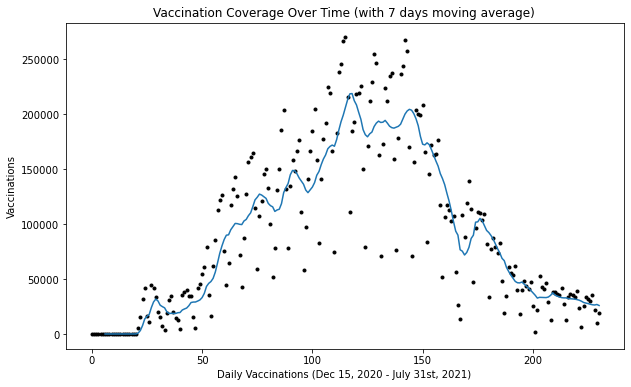

In [12]:
# # Calculating 7 days moving average of complete vaccination

complete = ca_vaccinated['fully_vaccinated']
complete.plot(style = 'k.', figsize=(10,6))
complete.rolling(window =7).mean().plot()

plt.title("Vaccination Coverage Over Time (with 7 days moving average) ")
plt.xlabel("Daily Vaccinations (Dec 15, 2020 - July 31st, 2021) ")
plt.ylabel("Vaccinations" )

plt.savefig("./CA_daily vaccinations vs 7-days moving average.png")
plt.show()

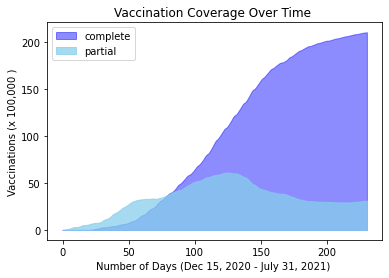

In [13]:
# Cumulative_vaccin_data for plotting vaccination coverage over time
# %matplotlib
dates = cumulative_vaccin_data['administered_date']
complete = cumulative_vaccin_data['cumulative_fully_vaccinated']/100000
partial = cumulative_vaccin_data['total_partially_vaccinated']/100000

# Plot the charts and apply some styling
plt.fill_between(np.arange(231), complete, color="blue", alpha=0.45, label='complete')
plt.fill_between(np.arange(231), partial, color="skyblue", alpha=0.75, label='partial')

plt.title("Vaccination Coverage Over Time ")
plt.xlabel("Number of Days (Dec 15, 2020 - July 31, 2021) ")
plt.ylabel("Vaccinations (x 100,000 )")

plt.legend(loc="upper left")
plt.savefig("./CA Cumulative Vaccinations coverage over time.png")
plt.show()

In [14]:
# Selecting only the residence county as reported in the data (elemination method is used)
ca_vaccin_data = csv_data.query('county !="All CA Counties"')
ca_vaccin_data = ca_vaccin_data.query('county !="All CA and Non-CA Counties"')
ca_vaccin_data = ca_vaccin_data.query('county !="Outside California"')
ca_vaccin_data = ca_vaccin_data.query('county !="Unknown"')

# getting new dataframe for total vaccination (fully and partially vaccinated) by counties

county_vac_data = ca_vaccin_data.groupby(ca_vaccin_data['county']).sum()

county_vac_data= pd.DataFrame(county_vac_data, columns =['partially_vaccinated', 'fully_vaccinated']).sort_values(by = \
                                                        'fully_vaccinated', ascending = False) 
# county_vac_data


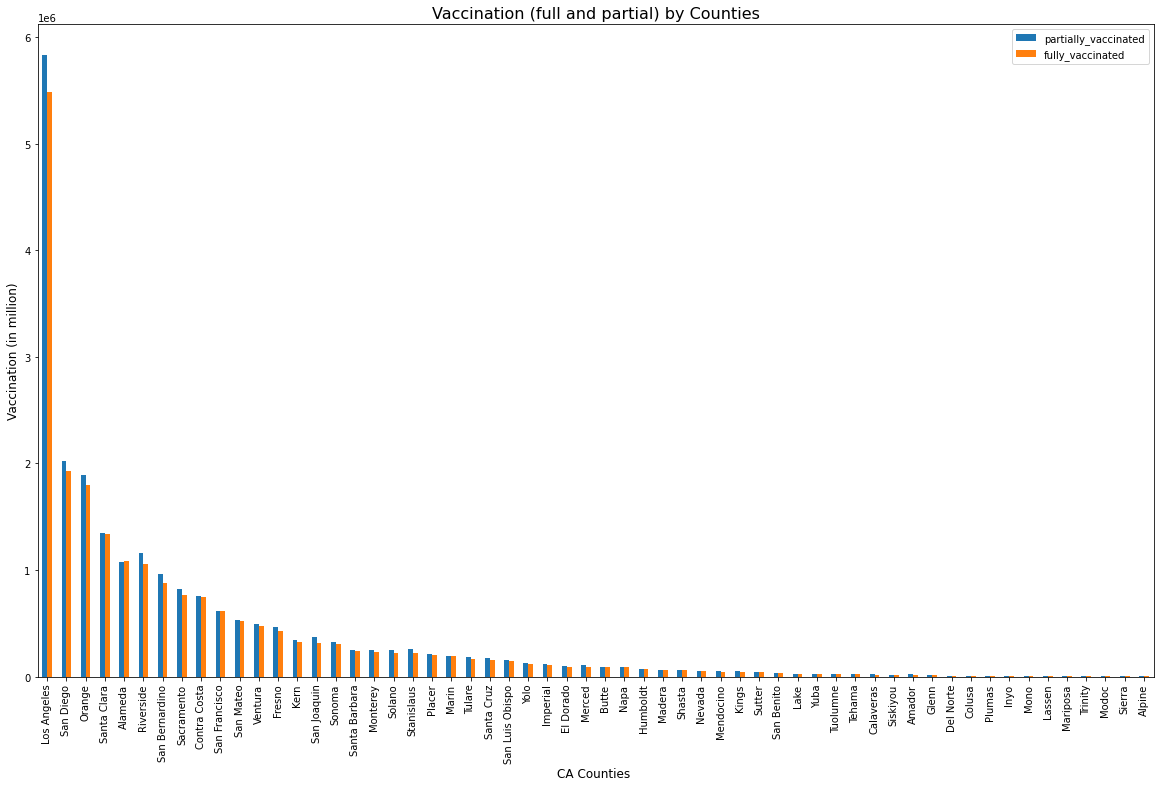

In [15]:
county_vac_data.plot(y = ['partially_vaccinated', 'fully_vaccinated'], kind='bar', figsize=(20,12))  #.bar(figsize=(16,9), color='g', alpha = 0.75)

plt.xlabel("CA Counties ",fontsize = 12)
plt.ylabel("Vaccination (in million)",fontsize = 12)
plt.title("Vaccination (full and partial) by Counties",fontsize = 16)
plt.savefig("./CA_Countywise vaccinations.png")
plt.show()


In [16]:
# Reading the data file for population by county
pop_data = pd.read_csv("./CA_county_pop.csv")   # Source: https://www.california-demographics.com/counties_by_population
pop_data = pd.DataFrame(pop_data)

''' In order to merge with the vaccination data, the population data was cleaned with their county names by removing the 
 word "County" from their names and merged to get a new datafile ''' 

county = []
county_name = pop_data['County']
for i in county_name:
        size = len(i)
        mod_name = i[:size-7]
        county.append(mod_name)

pop_data['county'] = county
county_pop_data = pop_data[['county', 'Population']]
pop = pop_data['Population']

county_pop_vac_data = pd.merge(county_pop_data, county_vac_data, on = 'county', how = 'left')

county_pop_vac_data.to_csv("./CA_county_population_and_vaccination_data.csv", index=False)
# print(county)

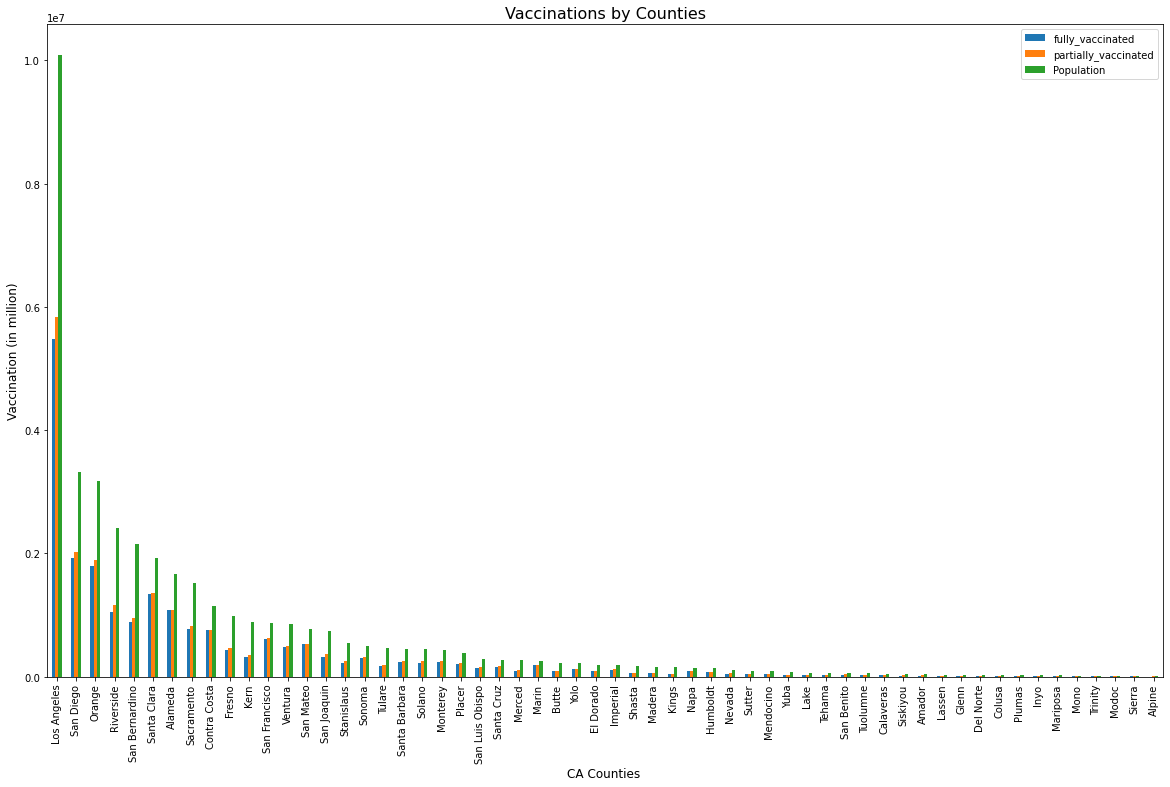

In [17]:
county_pop_vac_data = pd.read_csv("./CA_county_population_and_vaccination_data.csv", encoding = 'utf8')
county_pop_vac_data['Population'] = county_pop_vac_data['Population'].str.replace(',', '').astype(float)

county_pop_vac_data['Population']


county_pop_vac_data.plot(x="county", y = ['fully_vaccinated' ,'partially_vaccinated', 'Population'], kind="bar", figsize=(20,12))

plt.xlabel("CA Counties ",fontsize = 12)
plt.ylabel("Vaccination (in million)",fontsize = 12)
plt.title("Vaccinations by Counties",fontsize = 16)

plt.savefig("./CA_Countywise Population and vaccinations (complete and partial).png")

plt.show()




In [18]:
'''Since the chart based on the actual counts of population, and vaccinations, some of the highly populated counties are not
comparable to the low populated counties. Percentage of the vaccinations on total population is calculated and ploted.''' 

county_pop_vac_data['Population'] = county_pop_vac_data['Population'].astype(float)
county_pop_vac_data['fully_vaccinated'] = county_pop_vac_data['fully_vaccinated'].astype(float) 
county_pop_vac_data['partially_vaccinated'] = county_pop_vac_data['partially_vaccinated'].astype(float)

county_pop_vac_data['full_percent'] = (county_pop_vac_data['fully_vaccinated'] / county_pop_vac_data['Population']) * 100 
county_pop_vac_data['partial_percent'] = (county_pop_vac_data['partially_vaccinated'] / county_pop_vac_data['Population']) * 100

county_pop_vac_data['pop_percent'] = (county_pop_vac_data['Population'] / county_pop_vac_data['Population'].sum()) * 100 


average_pop = county_pop_vac_data['Population'].mean()
average_full = county_pop_vac_data['full_percent'].mean()
average_partial = county_pop_vac_data['partial_percent'].mean()

min_pop = county_pop_vac_data['Population'].min()
min_full = county_pop_vac_data['full_percent'].min()
min_partial = county_pop_vac_data['partial_percent'].min()

max_pop = county_pop_vac_data['Population'].max()
max_full = county_pop_vac_data['full_percent'].max()
max_partial = county_pop_vac_data['partial_percent'].max()

# full_stat = county_pop_vac_data['full_percent'].describe()
# partial_stat = county_pop_vac_data['partial_percent'].describe()
# pop_stat = county_pop_vac_data['pop_percent'].describe()

vac_stat = pd.DataFrame({
                        "% fully Vaccinated": {'minimum': min_full, 'average': average_full, 'maximum':max_full},
                        "% partially Vaccinated": {'minimum': min_partial, 'average': average_partial, 'maximum':max_partial}
})


# vac_stat = pd.DataFrame({
#                         "population" : pop_stat.map("{:,.2f}".format),
#                         "fully Vaccinated": full_stat.map("{:,.2f}".format),
#                         "Partially Vaccinated": partial_stat.map("{:,.2f}".format)})
vac_stat


,% fully Vaccinated,% partially Vaccinated
minimum,19.790382,18.696865
average,47.489891,50.787332
maximum,73.106027,78.729548


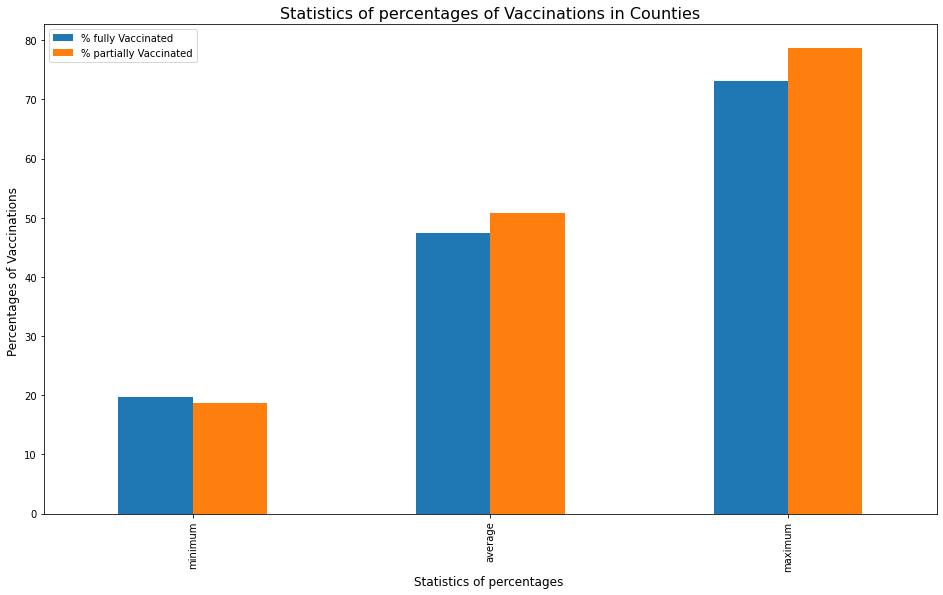

In [19]:
vac_stat.plot(y = ['% fully Vaccinated', '% partially Vaccinated'], kind='bar', figsize=(16,9))

plt.xlabel("Statistics of percentages ",fontsize = 12)
plt.ylabel("Percentages of Vaccinations ",fontsize = 12)
plt.title("Statistics of percentages of Vaccinations in Counties",fontsize = 16)

plt.savefig("./Statistics of percentages of Vaccinations in Counties (complete and partial).png")
plt.show()


In [75]:
vaccin_doses_by_dates

,administered_date,total_doses,partially_vaccinated,fully_vaccinated,at_least_one_dose
0,12/15/2020,1188,1188,0,1188
1,12/16/2020,8761,8761,0,8761
2,12/17/2020,26792,26794,0,26794
3,12/18/2020,45570,45570,1,45570
4,12/19/2020,25657,25656,1,25656
...,...,...,...,...,...
226,7/29/2021,76466,45950,29829,49558
227,7/30/2021,89763,53091,35760,56991
228,7/31/2021,56117,33701,21819,35940
229,8/1/2021,28162,18298,9603,19125


In [84]:
percent_daily_vac

0      0.000030
1      0.000223
2      0.000682
3      0.001160
4      0.000653
         ...   
226    0.001262
227    0.001451
228    0.000915
229    0.000487
230    0.000839
Name: at_least_one_dose, Length: 231, dtype: float64

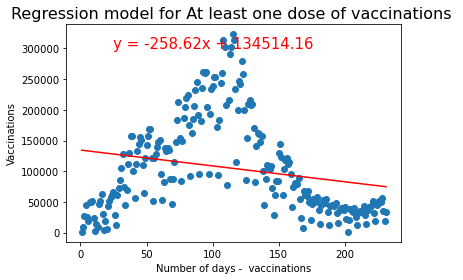

R(square) = 0.049391962934717704 and p-value = 0.0006686420116539369. 
As the statistics shows it can be estimated that the vaccination will be completed in about 521 days 
 remaining all other compounding factors unchanged


In [98]:
from datetime import date
d0 = date(2020, 12, 15)
d1 = date(2021, 8, 3)
delta = d1 - d0
number_of_days = delta.days
days = range(1, number_of_days+1)
# days

# CA_pop = 39283497
# percent_daily_vac = 100 * (vaccin_doses_by_dates['at_least_one_dose']/CA_pop)

# Perform a linear regression on vaccination by days 
x_value = days

y_value = vaccin_doses_by_dates['at_least_one_dose']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_value, y_value)
regress_value = x_value * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.scatter(x_value,y_value)
plt.plot(x_value,regress_value,"r-")

plt.annotate(line_eq,(25,300000),fontsize=15,color="red")

plt.xlabel('Number of days -  vaccinations')
plt.ylabel('Vaccinations')
plt.title("Regression model for At least one dose of vaccinations ",fontsize = 16)
plt.savefig("./CA_At least one dose of vaccinations by number of days.png")
plt.show()
print(f"R(square) = {rvalue**2} and p-value = {pvalue}. \n"
      f"As the statistics shows it can be estimated that the vaccination will be completed in about 521 days \n"
      f" remaining all other compounding factors unchanged")

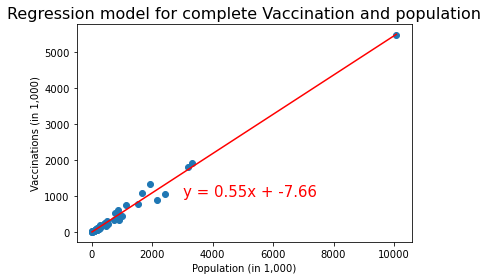

r = 0.9945486974664242 and p-value = 1.1113657983791348e-56


In [20]:
# Perform a linear regression on population versus complete vaccination
x_value = county_pop_vac_data['Population']/1000
y_value = county_pop_vac_data['fully_vaccinated']/1000
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_value, y_value)
regress_value = x_value * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.scatter(x_value,y_value)
plt.plot(x_value,regress_value,"r-")
plt.annotate(line_eq,(3000,1000),fontsize=15,color="red")
plt.xlabel('Population (in 1,000)')
plt.ylabel('Vaccinations (in 1,000)')
plt.title("Regression model for complete Vaccination and population",fontsize = 16)
plt.savefig("./CA_population and complete vaccinations correlation.png")
plt.show()

print(f"r = {rvalue} and p-value = {pvalue}")


In [21]:
# Gettign geo location of California Counties
us_county_geo = pd.read_csv("./uscounties_geolocation.csv")   # Source: https://simplemaps.com/data/us-counties (updated 02/24/2021)
ca_county_geo = us_county_geo.query('state_id == "CA"')
ca_county_geo = pd.DataFrame(ca_county_geo, columns = ['county', 'lat', 'lng'])

# Merging vaccination data with the geolocation data by counties
county_pop_vac_geo = pd.merge(county_pop_vac_data, ca_county_geo, on = 'county', how = 'left')

# Selecting counties with more than 55% fully vaccinated (higher than the state average)
county_pop_vac_geo_55 = county_pop_vac_geo.loc[(county_pop_vac_geo["full_percent"] > 55)]

# rounding the decimals in two
county_pop_vac_geo_55 = county_pop_vac_geo_55.round(decimals=2)
county_pop_vac_geo_55 = county_pop_vac_geo_55.sort_values('full_percent', ascending =False)
county_pop_vac_geo_55


,county,Population,partially_vaccinated,fully_vaccinated,full_percent,partial_percent,pop_percent,lat,lng
25,Marin,259943.0,193612.0,190034.0,73.11,74.48,0.66,38.07,-122.72
11,San Francisco,874961.0,618479.0,614281.0,70.21,70.69,2.23,37.76,-122.44
5,Santa Clara,1927470.0,1351031.0,1333873.0,69.20,70.09,4.91,37.23,-121.70
13,San Mateo,767423.0,533722.0,520751.0,67.86,69.55,1.95,37.42,-122.33
57,Alpine,1039.0,818.0,688.0,66.22,78.73,0.00,38.60,-119.82
8,Contra Costa,1142251.0,756072.0,747826.0,65.47,66.19,2.91,37.92,-121.93
6,Alameda,1656754.0,1072682.0,1080140.0,65.20,64.75,4.22,37.65,-121.89
33,Napa,139623.0,93828.0,86949.0,62.27,67.20,0.36,38.51,-122.33
16,Sonoma,499772.0,321936.0,307066.0,61.44,64.42,1.27,38.53,-122.89
1,San Diego,3316073.0,2018518.0,1927095.0,58.11,60.87,8.44,33.03,-116.74


In [22]:
#Almost 1/3 of the total counties are fully vaccinated higher than state average. 
#Marin county and San Francisco county have more than 70% complete vaccination.


In [23]:
# Creating map for counties with the vaccination coverages

from api_keys import g_key

gmaps.configure(api_key=g_key)


# Store latitude and longitude in locations
locations = county_pop_vac_geo[["lat", "lng"]]
vaccination_coverage = county_pop_vac_geo['fully_vaccinated']

# Plot Heatmap
fig = gmaps.figure()

# Create heat layer
heat_layer = gmaps.heatmap_layer(locations, weights = vaccination_coverage, dissipating=False,\
                                 max_intensity= 5000, point_radius=0.3)

# Add layer
fig.add_layer(heat_layer)

# Display figure
fig

Figure(layout=FigureLayout(height='420px'))

In [24]:
from api_keys import g_key
gmaps.configure(api_key=g_key)

# locations
locations_55 = county_pop_vac_geo_55[["lat", "lng"]]

info_box_template = """
<dl>
<dt>County:</dt><dd>{county}</dd>
<dt>Population: </dt><dd>{Population}</dd>
<dt>Fully Vaccinated </dt><dd>{fully_vaccinated}</dd>
<dt>% Fully Vaccinated</dt><dd>{full_percent}</dd>
<dt>Partially Vaccinated</dt><dd>{partially_vaccinated}</dd>
<dt> % Partially Vaccinated</dt><dd>{partial_percent}</dd>
</dl>
"""

county_info = [info_box_template.format(**row) for index, row in county_pop_vac_geo_55.iterrows()]

# locations = county_pop_vac_geo_55[["lat", "lng"]]

# Add marker layer ontop of heat map
markers = gmaps.marker_layer(locations_55, info_box_content = county_info)
fig = gmaps.figure()
fig.add_layer(markers)

# Display figure
fig


Figure(layout=FigureLayout(height='420px'))